# 0. Dependencies and notebook settings

In [483]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to create a inline image when using jupyter notebook with higher quality using seaborn style
%matplotlib inline  
%config InlineBackend.figure_format = 'retina' #or svg
plt.style.use('seaborn')
#======= progress ======#
from ipywidgets import FloatProgress
from IPython.display import display
import time

# Data Description

Two series of data are used in this study. A TSP file containing 16 and 96 data points each in `Swarm016.tsp` and `Swarm096.tsp`. These files represents datapoints in 2 Dimensional space.

In [444]:
data16 = pd.read_csv('Swarm016.tsp',delimiter =" ", index_col=0 )
data96 = pd.read_csv('Swarm096.tsp',delimiter =" ", index_col=0 )

### Data visualizaiton function
In order to make it easier to use in repetitive way, I wrap the scatter steps (using matplotlib) as follow : 

In [445]:
def ib_scatterhs_2d(datas,naxes,titles,dpi=50
                    ,suptitle="Data Visualization"
                    ,figsize=(0,0), route=[]
                    ,node_color='k',edge_color='k',s=30
                    ,verbouse=False, sharex=False, sharey=False, print_route=False, ):
    
    if(naxes == 1):
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize,sharex=sharex, sharey=sharey)
        ax.scatter(datas[0]['X'], datas[0]['Y'], alpha=1, color=node_color,s=s, label="city",zorder=2)
        ax.set_title(titles[0]); ax.legend(loc=2)
        if verbouse:
            xmax,xmin,ymax,ymin = np.max(datas[0]['X']),np.min(datas[0]['X']),np.max(datas[0]['Y']),np.min(datas[0]['Y'])
            x_off, y_off = (xmax-xmin)*0.008, (ymax-ymin)*0.02
            for j in range(len(datas[0])):
                ax.annotate(j, (datas[0]['X'].iloc[j]-x_off, datas[0]['Y'].iloc[j]+y_off))
        if print_route:
            route_data = datas[0].iloc[route[0]]
            ax.plot(route_data['X'], route_data['Y'],color=edge_color,lw=1.5, zorder=1)
                    
    else:
        fig, axes = plt.subplots(1, naxes, dpi=dpi, figsize=figsize,sharex=sharex, sharey=sharey)
        for i, ax in enumerate(axes):
            ax.scatter(datas[i]['X'], datas[i]['Y'], alpha=1, color=node_color,s=s, label="city", zorder=2)
            ax.set_title(titles[i]); ax.legend(loc=2)
            if verbouse:
                xmax,xmin,ymax,ymin = np.max(datas[i]['X']),np.min(datas[i]['X']),np.max(datas[i]['Y']),np.min(datas[i]['Y'])
                x_off, y_off = (xmax-xmin)*0.008, (ymax-ymin)*0.02
                for j in range(len(datas[i])):
                    ax.annotate(j, (datas[i]['X'].iloc[j]-x_off, datas[i]['Y'].iloc[j]+y_off))
            if print_route:
                route_data = datas[i].iloc[route[i]]
                ax.plot(route_data['X'], route_data['Y'],color=edge_color,lw=1.5, zorder=1)
                    
    fig.suptitle(suptitle, fontsize=24)
    
#     plt.scatter(datas['X'], datas['Y'],s=80,color='b', zorder=1)
#     plt.plot(datas['X'], datas['Y'],color='0.2',lw=1.5, zorder=2
         
    plt.show()

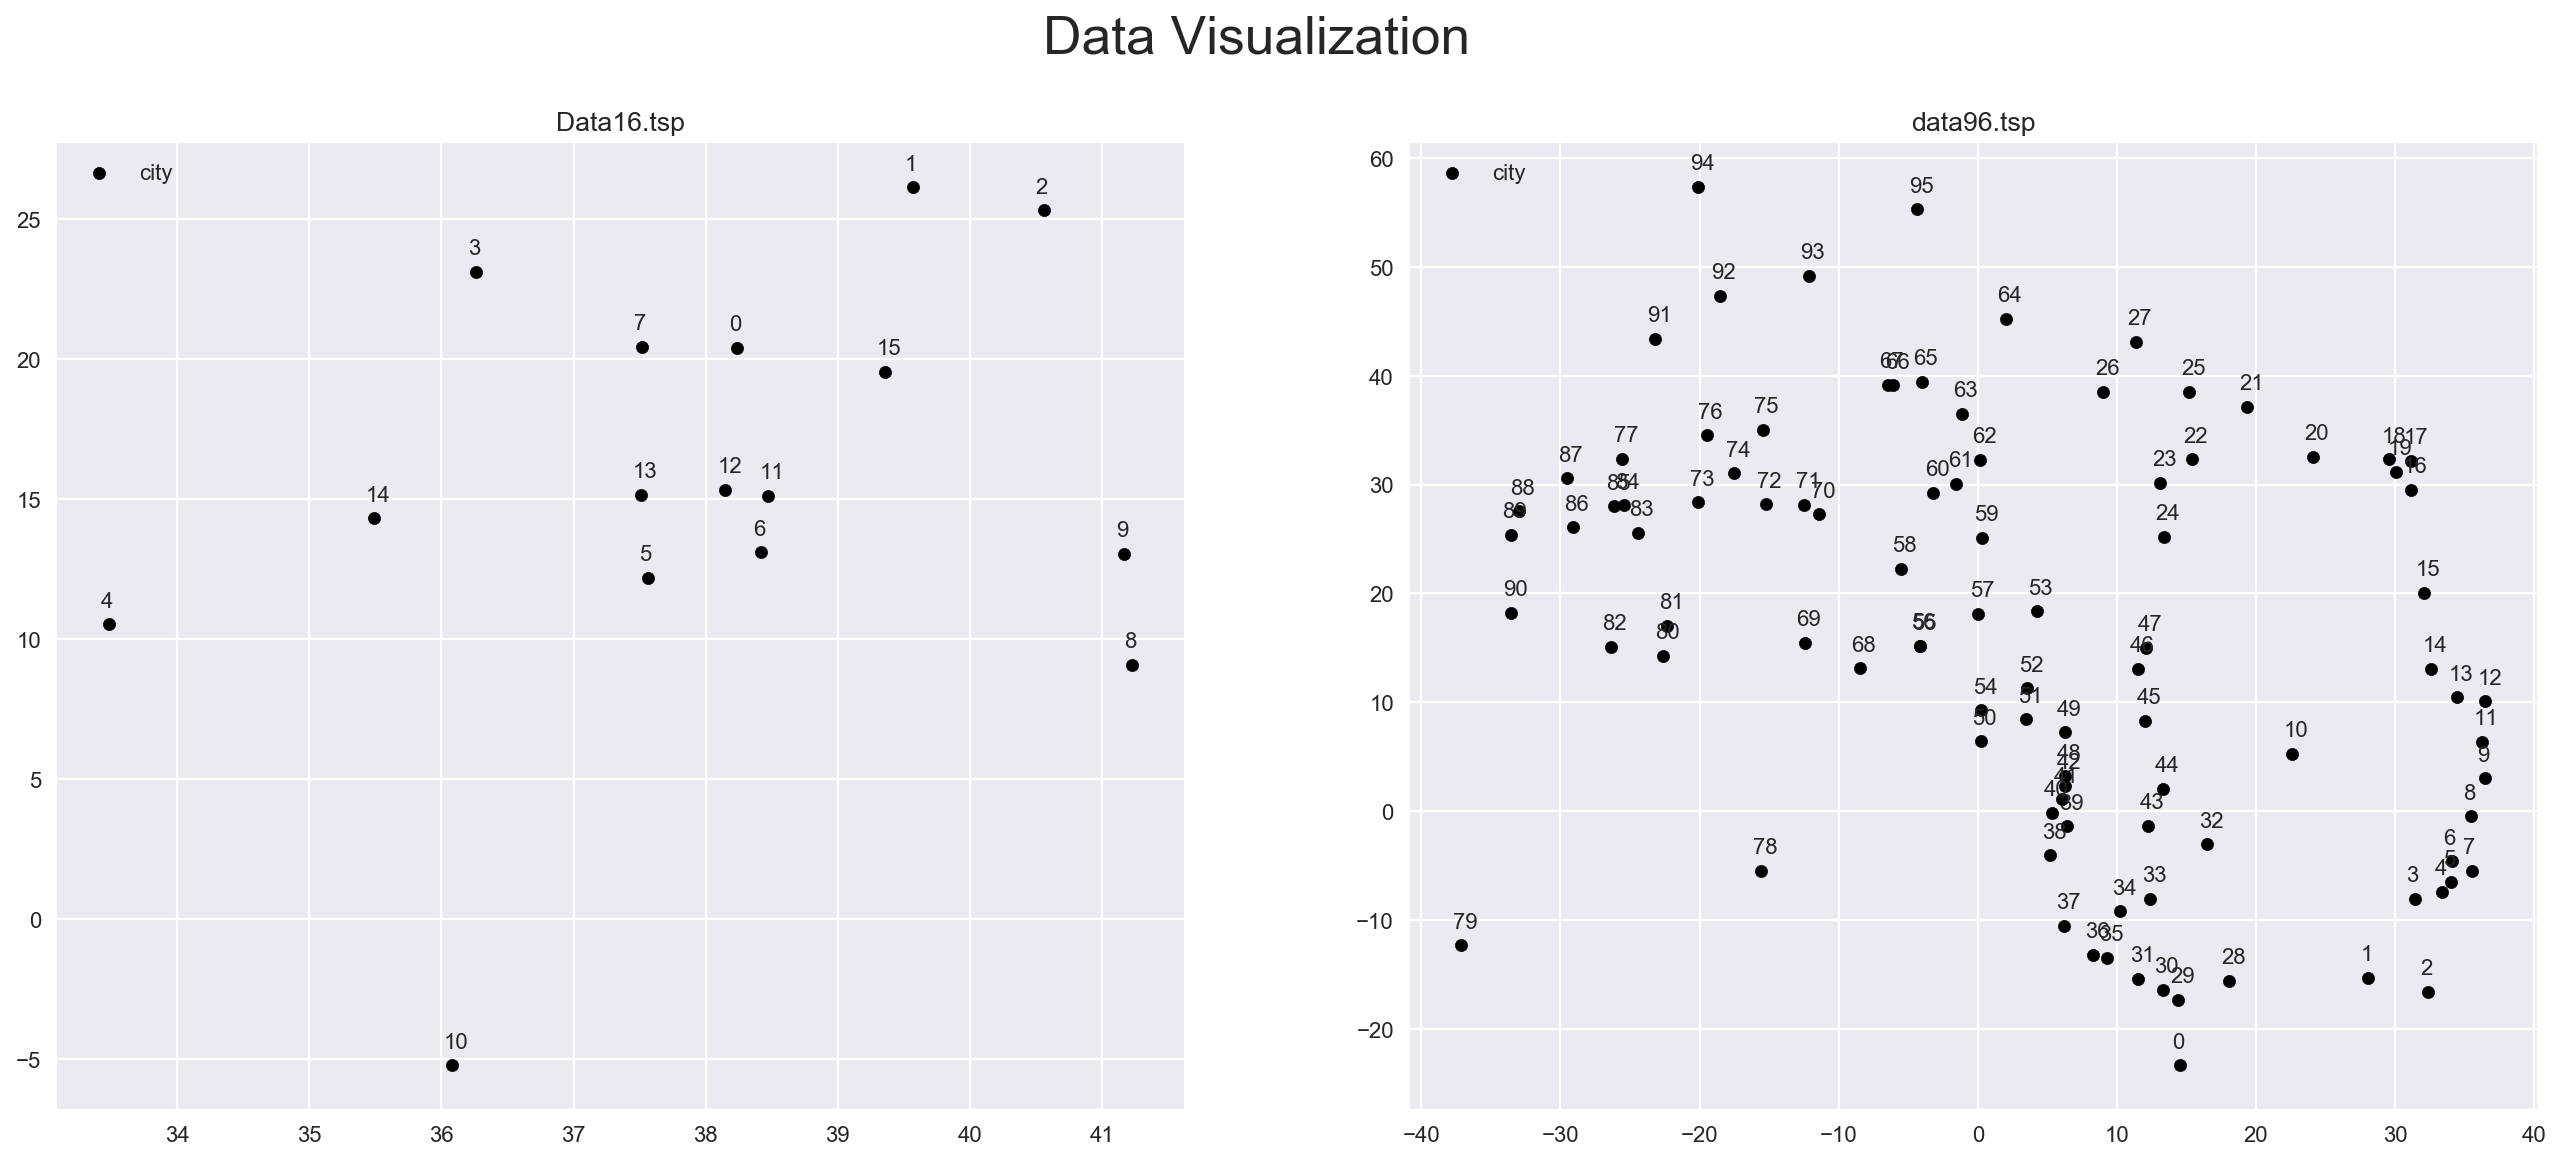

In [446]:
datas = [data16, data96]
axes = 2
titles = ['Data16.tsp', 'data96.tsp']
ib_scatterhs_2d(datas,axes,titles,dpi=80,figsize=(20,8),verbouse=True)

# Solution Model


# Sparse Matrix of Distance

### Method #1 : Use 3rd party library : Scipy
*[See documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html)*

In [443]:
from scipy.spatial import distance_matrix
dist_matrix_16 = distance_matrix(data16.values,data16.values, p=2) 
dist_matrix_96 = distance_matrix(data96.values,data96.values, p=2) 

In [345]:
print(dist_matrix_16.shape, dist_matrix_96.shape)
print(type(dist_matrix_16), type(dist_matrix_96))

(16, 16) (96, 96)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Method #2 : Own function

In [346]:
# Create function 
def ib_distance_matrix(matrix1, matrix2, p=2):
    """
    INPUT : 
        - Matrix1 
        - Matrix 2
        - p : integer, p-norm distance. Default is 2 (euclidian distance)
    """
    dist= lambda p1,p2 :((np.absolute(p1-p2))**p).sum()**(1/p)
    dist_matrix = np.asarray([[dist(p1, p2) for p2 in matrix2] for p1 in matrix1])
    
    return dist_matrix

In [347]:
dm1 = distance_matrix(data16.values,data16.values,p=2) 
dm2 = ib_distance_matrix(data16.values,data16.values,p=2)
(dm1==dm2).mean() == 1 #if return True, means that dm1 == dm2

True

### Performance measure

In [348]:
def my_func():
    return ib_distance_matrix(data16.values,data16.values,p=2)
def not_my_func():
    return distance_matrix(data16.values,data16.values,p=2) 

In [349]:
import timeit
n = [1,10,100,1000]
cmpr = []
for i in n:
    cmpr.append([timeit.timeit(my_func, number=i) , timeit.timeit(not_my_func, number=i), i])
cmpr = np.asarray(cmpr)

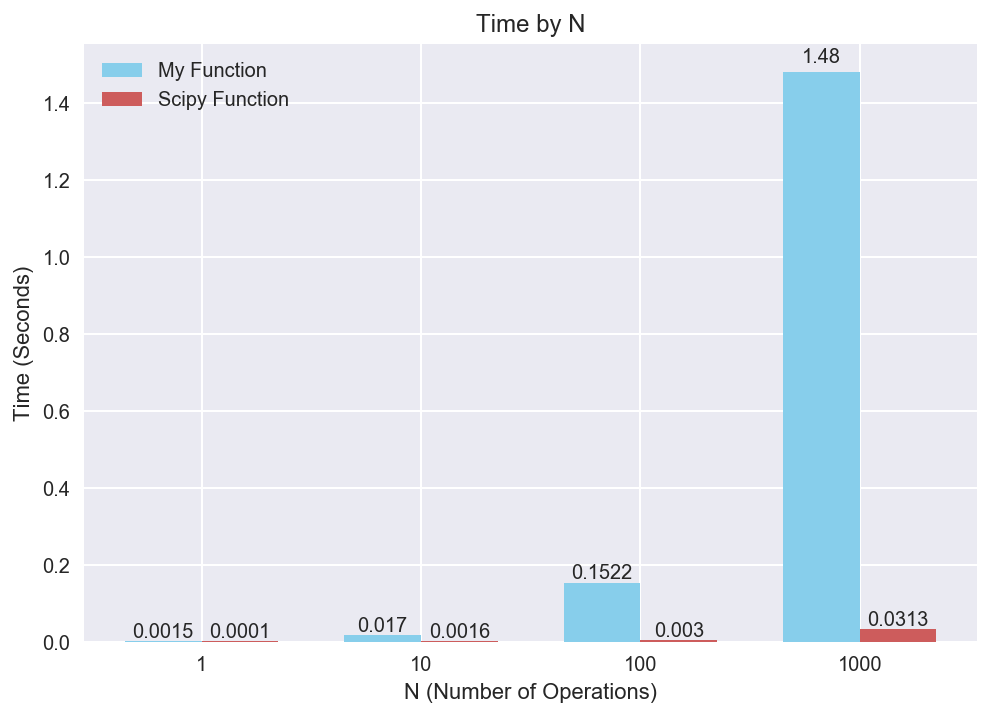

In [350]:
ind = np.arange(len(cmpr[:,0]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, np.around(tuple(cmpr[:,0]), decimals=4), width, color='SkyBlue', label='My Function')
rects2 = ax.bar(ind + width/2, np.around(tuple(cmpr[:,1]), decimals=4), width, color='IndianRed', label='Scipy Function')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (Seconds)')
ax.set_xlabel('N (Number of Operations)')
ax.set_title('Time by N')
ax.set_xticks(ind)
ax.set_xticklabels(('1', '10', '100', '1000'))
ax.legend()
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()

# Pheromone Matrices

Pheromone matrix is square shape of N matrix (same as distance matrix) that contains a pheromone of specific path between two nodes or city. By the initialization, we will have a pheromone matrix of very small value (just to avoid zero division in finding routes. 


In [351]:
def new_pherm_matrix(n,value):
    return np.full((n,n), value, dtype='float64')

# Hyper Parameter and Variables
### Hyper Parameter: 
- $N$ , Representing number of ants
- $NC$ , Representing number of cycles
- $\alpha, \beta$, Representing importance level of pheromone and visibility respectively
- $1-\rho$, Representing Evaporation Coefficient
- $Q$, a constant

### Variables:
- $\tau_{ij}(t)$, Representing Pheromones between $city_i$ and $city_j$ on time $t$
- $\Delta\tau_{ij}$, Representing addition of pheromones between $city_i$ and $city_j$ if any ant(s) passed the path
- 

# Objective Function
(Will be implemented **inside** route generation function)

In [352]:
def cost(route,distance_matrix, verbouse = False):
    """
    INPUT :
        Route : a list of visited city sequentially (included first node as final destination)
        distance_matrix  : sparse matrix that contains distance between cities
        verbouse : boolean value to print the information while running
    OUTPUT 
        a float number representing the distance of the route
    """
    dist = 0
    for i in range(len(route)-1):
        dist += distance_matrix[route[i],route[i+1]]
        if (verbouse):
            print ("step", i, "city", route[i], "to", route[i+1], ", Ditance = ", dist)
    return dist

# Pheromone update

$\tau_{ij}(t+n) = \rho\ \tau_{ij}(t) + \Delta\tau_{ij}$,

In [353]:
def pheromones_update(pheromones, delta_pheromones, rho):
    pheromones *= rho
    pheromones += delta_pheromones
    return pheromones

In [354]:
def pheromones_delta_count(route, Qpc, verbouse=False):
    """
    Qpc = Q / Cost(route)
    """
    size = len(route)
    delta_pheromone = new_pherm_matrix(size-1,0)
    for i in range(size-1):
#         delta_pheromone[route[i+1], route[i]] += Qpc
        delta_pheromone[route[i], route[i+1]] += Qpc
        
    if verbouse:
            print("Generate delta Pheromone for Q/Cost : {} with size {} is done".format(Qpc, size-1))
    return delta_pheromone

# Route Finding

### next route probability
$$ P_{ij}^k(t) = \frac{[\tau_{ik}(t)]^{\alpha} \cdot [\eta_{ik}]^{\beta}}  
{\Sigma_{\ k\  \in\ allowed_k} [\tau_{ik}(t)]^{\alpha} \cdot [\eta_{ik}]^{\beta} } $$ 

if $j \in $ allowed, and
$$ P_{ij}^k(t) = 0 $$ if $j \notin$ allowed


Note : $\eta_{ij} = \frac{1}{d_{ij}}$



In [355]:
def nr_prob(current_node,allowed_nodes, distances, pheromones, alpha, beta, verbouse = False):
    """
    Next Route Probability Function. This function will calculate the probability of choosing next city
    that will be added in route. 
    Input : 
    - Current Node
    - Allowed Nodes
    - Distance Matrix
    - Pheromones Matrix
    - Alpha
    - Beta
    Output : 
    - Next Node
    - Distance to Next Node
    """
    p = []
    sigma_p = 0
    
    for i in allowed_nodes:
        prob = pheromones[current_node, i]**alpha + (1/distances[current_node, i])**beta
        p.append(prob)
        sigma_p += prob
        if verbouse:
            print("{p1}->{p2} Distance : {d}, probability: {prb}"
                  .format(p1=current_node,p2=i, d=distances[current_node,i], prb=prob))
    
    p = np.asarray(p) / sigma_p
    next_node = allowed_nodes[np.argmax(p)]
    
    return next_node, distances[current_node,next_node]

### Generate Route
After we have the probability function, we can wrap them to make higher method, generate route. 

In [356]:
def Generate_tour(init_node,nodes, distance_matrix, pheromone_matrix, alpha, beta, Q=0.2, verbouse = False):
    """
    INPUT :
        -Init_node : initial node to start the tour
        -nodes : list, all nodes available in the map (excluding initial node)
        -distance_matrix : matrix
        -pheromone_matrix
        -alpha
        -beta
        -Q
    Output : 
        -list containing order of visited city as route (including initial node as final destination) 
        -cost of the tour
        -delta_pheromone for the route
    """
    
    tabu_list = nodes
    route = [init_node]
    total_bounce = len(tabu_list)
    total_dist = 0
    
    if verbouse : 
        print("Start Generating tour for {a} cities from city {b} ".format(a=total_bounce+1, b=init_node))
    
    for i in range(total_bounce):
        next_node, dist = nr_prob(route[-1],tabu_list, distance_matrix, pheromone_matrix, alpha, beta)
        tabu_list.remove(next_node)
        route.append(next_node)
        total_dist += dist
        if verbouse : 
            print("Bounce #{no}: {p1}->{p2} (Dist = {d}) "
                  .format(no=i+1, p1=route[-2], p2=next_node
                  , d=distance_matrix[route[-2],route[-1]] ))
            
    route.append(init_node)
    total_dist += distance_matrix[route[-2],route[-1]]
    if verbouse : 
        print("Last Bounce: {p1}->{p2} (Dist = {d}) "
              .format(no=i+1, p1=route[-2], p2=route[-1]
              , d=distance_matrix[route[-2],route[-1]] ))
    
    delta_pheromone = pheromones_delta_count(route, Q/total_dist, verbouse = verbouse)
    return route, total_dist, delta_pheromone
    

In [357]:
cost(route, dist_matrix_16)


84.43362518362554

# Route Visualization
Using visualization method created on previous section, we can visualize the route

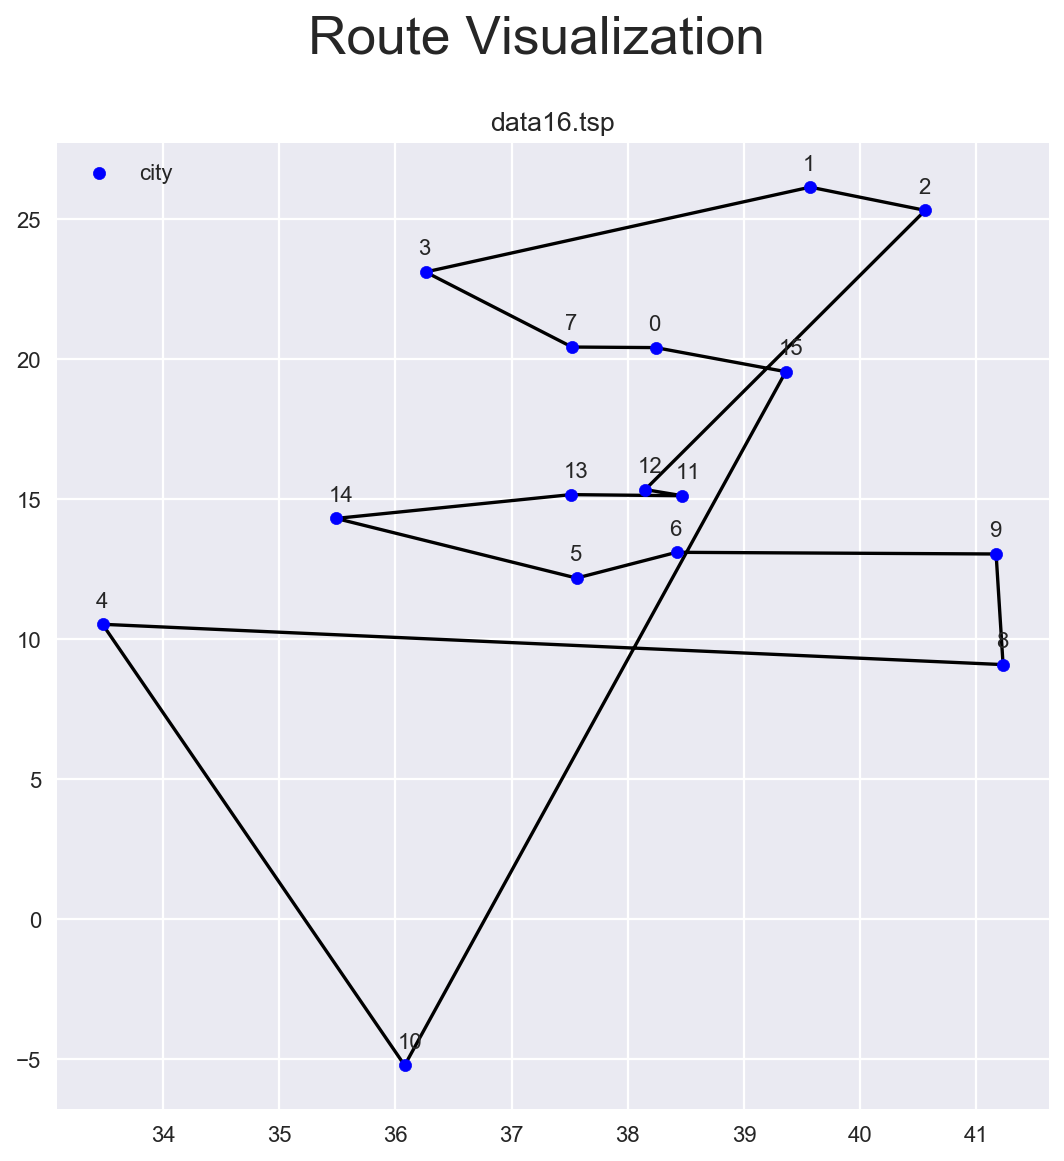

In [358]:
datas = [data16]
axes = 1
titles = ["data16.tsp"]
ib_scatterhs_2d(datas,axes,titles,dpi=80,node_color='b'
                ,figsize=(8,8),route=route, suptitle="Route Visualization"
                , print_route=True, verbouse = True)

# Ants Initialization
This will create a $N_{ant}$ ants as out agents

In [359]:
def initialize_ants(N_ant, Nodes):
    """
    Input : 
    - N_ant : integer, number of ants
    - Nodes : List of nodes
    Output : 
    List that containt N_ant number of specific point in Nodes (selected randomly but uniform)
    """
    
    initial_ant = np.random.choice(Nodes, N_ant)
    return initial_ant

In [490]:
def ant_system(N_ant, Nodes, N_cycle, distances, pheromones, alpha, beta, rho, Q, random=True, verbouse=False):
    final_route = None
    final_cost = np.inf
    
    fcl = [] #final cost list
    mcl = [] #mean cost list
    
    max_count = len(Nodes)
    f = FloatProgress(min=0, max=max_count, description='Progress', bar_style='success') # instantiate the bar
    display(f) # display the bar

    for cycle in range(N_cycle):
        
        if not random:
            initial_node = Nodes
        else:         
            initial_node = list(initialize_ants(N_ant, Nodes))
        #======== Temporary Variables ======= #
        total_dtau = new_pherm_matrix(len(Nodes),0)
        best_route = None
        best_cost = np.inf
        cl = []
        #======== Temporary Variables ======= #
        for ant in initial_node:
            current_node = ant
            allowed_node = list(range(len(Nodes))); 
#             allowed_node = Nodes
            allowed_node.remove(current_node)
            route, total_dist,d_tau = Generate_tour(current_node,allowed_node
                                                    , distances, pheromones, alpha, beta
                                                    ,Q=Q
                                                    , verbouse=False)
            total_dtau += d_tau
            if total_dist < best_cost :
                best_route = route
                best_cost = total_dist
                
            cl.append(best_cost)
        pheromones = pheromones_update(pheromones, total_dtau, rho)
        if best_cost < final_cost :
                final_route = best_route
                final_cost = best_cost
        
        
        mcl.append(np.mean(cl))
        fcl.append(final_cost)
        f.value += 1
        
    fig, (ax1, ax2) = plt.subplots(1,2,dpi=80, figsize=(20,8))
    ax1.plot(fcl) ; ax1.set_title("Best Route Behaviour")
    ax1.set_xlabel("Cycle"); ax1.set_ylabel("Best Route")
    ax2.plot(mcl) ; ax2.set_title("Mean Route Behaviour")
    ax2.set_xlabel("Cycle"); ax2.set_ylabel("Best Route")
    plt.show()
    
   
        

    return fcl, mcl, final_route, final_cost

# Main Program

A Jupyter Widget

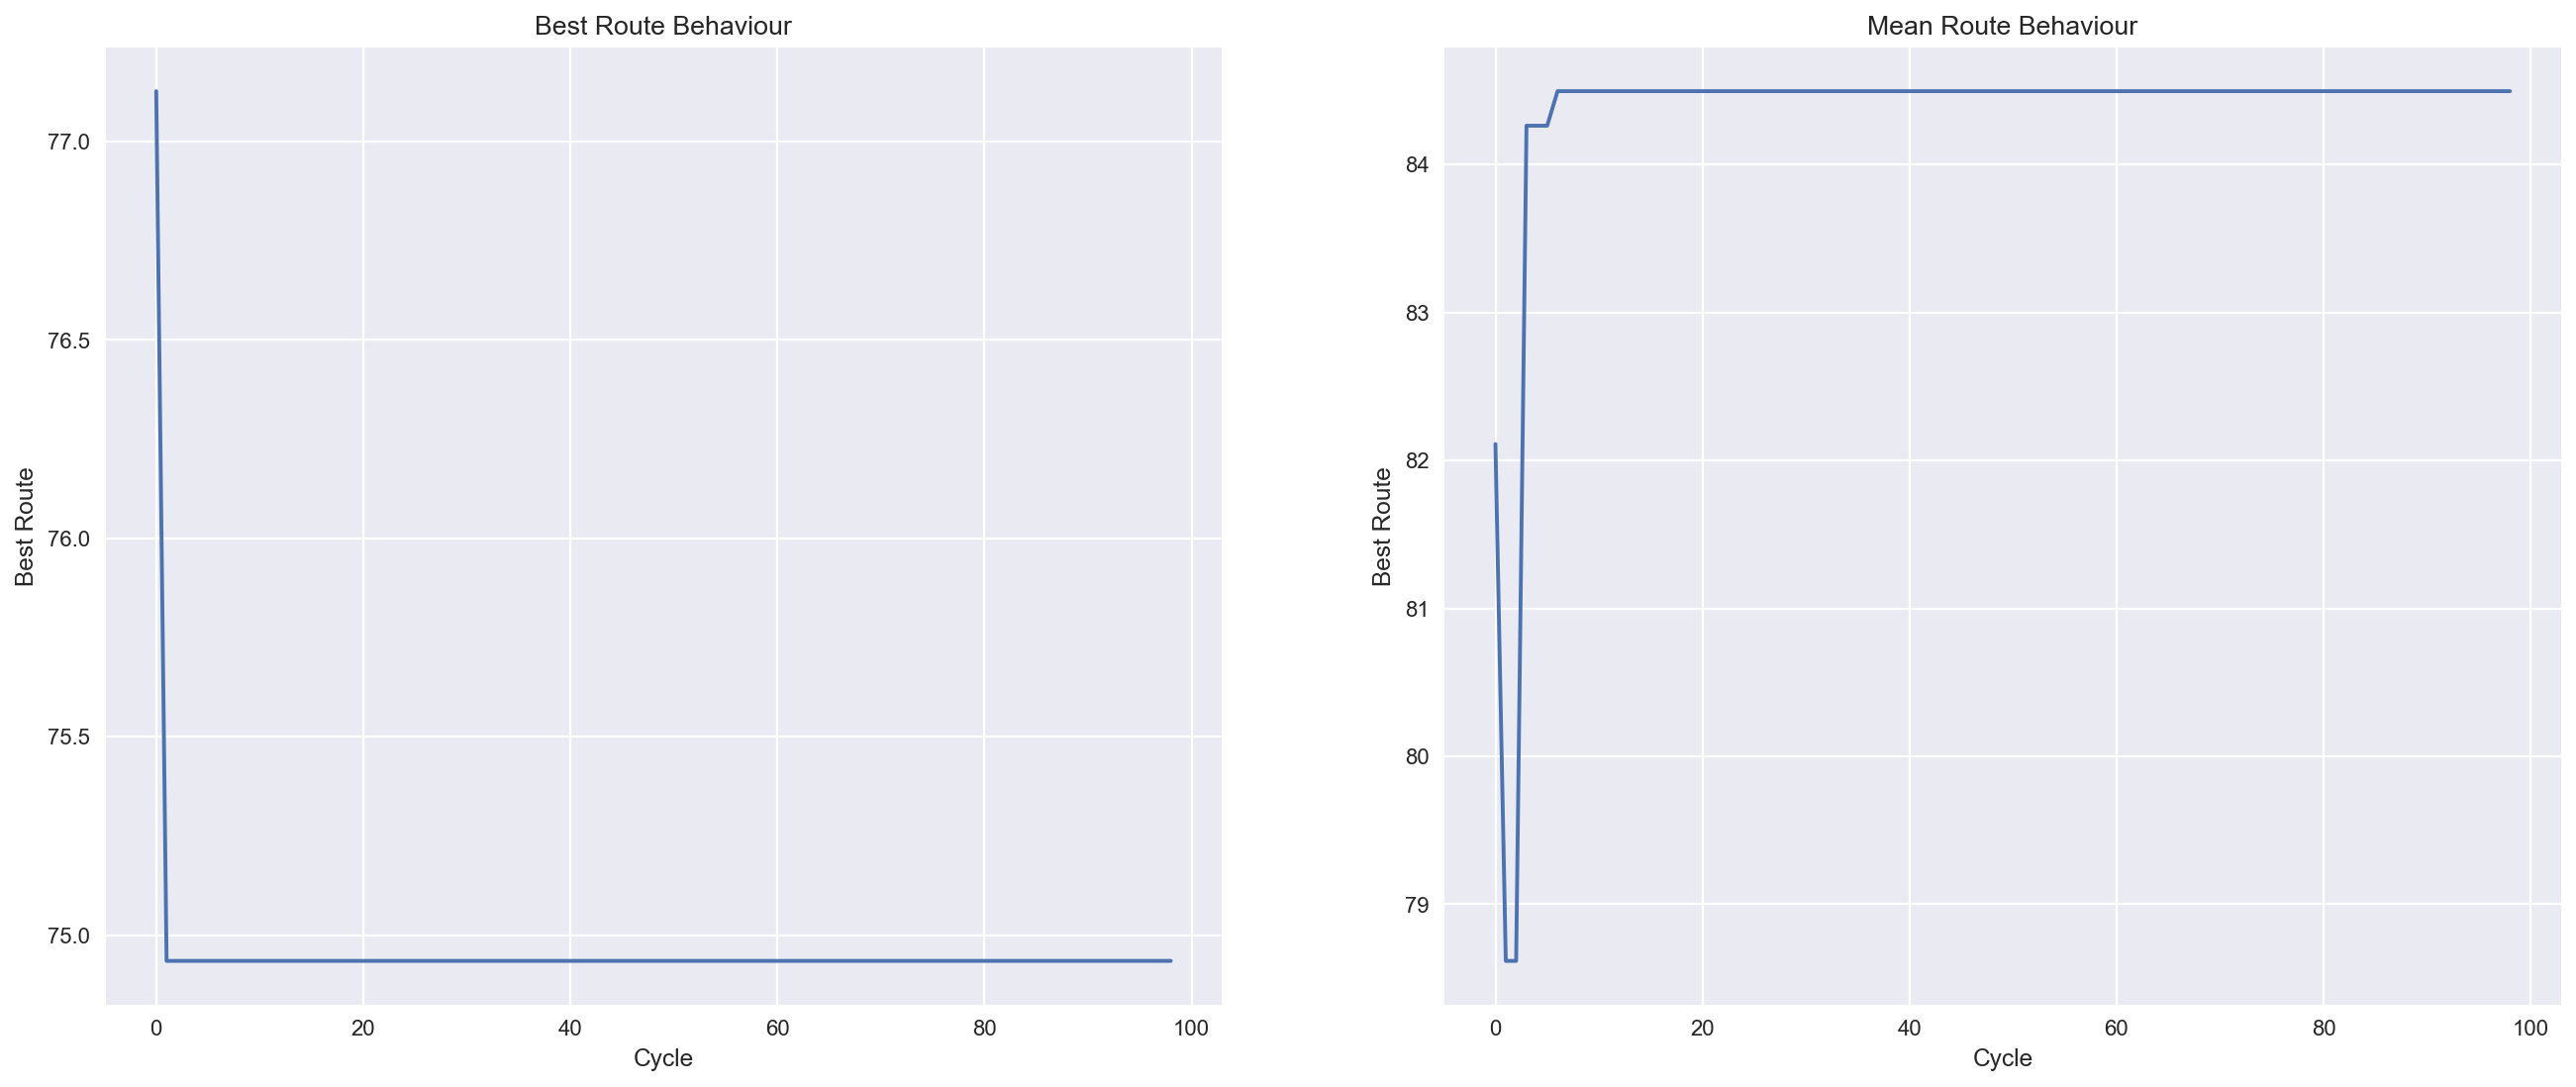

In [491]:
# ================ Initialization ================ #
N16 = list(np.arange(16)) ; N96 = list(np.arange(96))
Cycle16 = 100 ; Cycle96 = 100
alpha16 = 10 ; alpha96 = 15
beta16 = 20 ; beta96 = 20
rho16 = 0.7 ; rho96 = 0.5
Q16= 0.8 ; Q96= 0.1

dist16 = distance_matrix(data16.values,data16.values, p=2) 
dist96 = distance_matrix(data96.values,data96.values, p=2)
 
pheromones16 = new_pherm_matrix(16,0.01)
pheromones96 = new_pherm_matrix(96,0.01)

# ================ Main Functino ==================#
fcl, mcl, final_route, final_cost = ant_system(16, N16, cycle, \
                                               dist16, pheromones16, \
                                               alpha16, beta16, rho16,\
                                               Q16, random=False
                                               , verbouse=True)


In [ ]:
troute = [13,0,7,3,1,2,15,9,8,10,4,14,5,6,11,12,13]
datas = [data16, data16]
axes = 2
this_routes = [final_route, troute]
titles = ["My Route: "+str(cost(final_route, dist16)), "Best Route: "+str(cost(troute, dist16))]
# ib_scatterhs_2d(datas,axes,titles,dpi=80,node_color='b'
#                 ,figsize=(5,5),route=final_route, suptitle="Route Visualization"
#                 , print_route=True, verbouse = True)

ib_scatterhs_2d(datas,axes,titles,dpi=80,node_color='b'
                ,figsize=(20,8),route=this_routes, suptitle="Route Visualization"
                , print_route=True, verbouse = True)
print("Accuracy = 1-(mycost - bestcost)/bestcost : {}".format(1-(cost(final_route, dist16)-cost(troute, dist16))/cost(troute, dist16)))

A Jupyter Widget

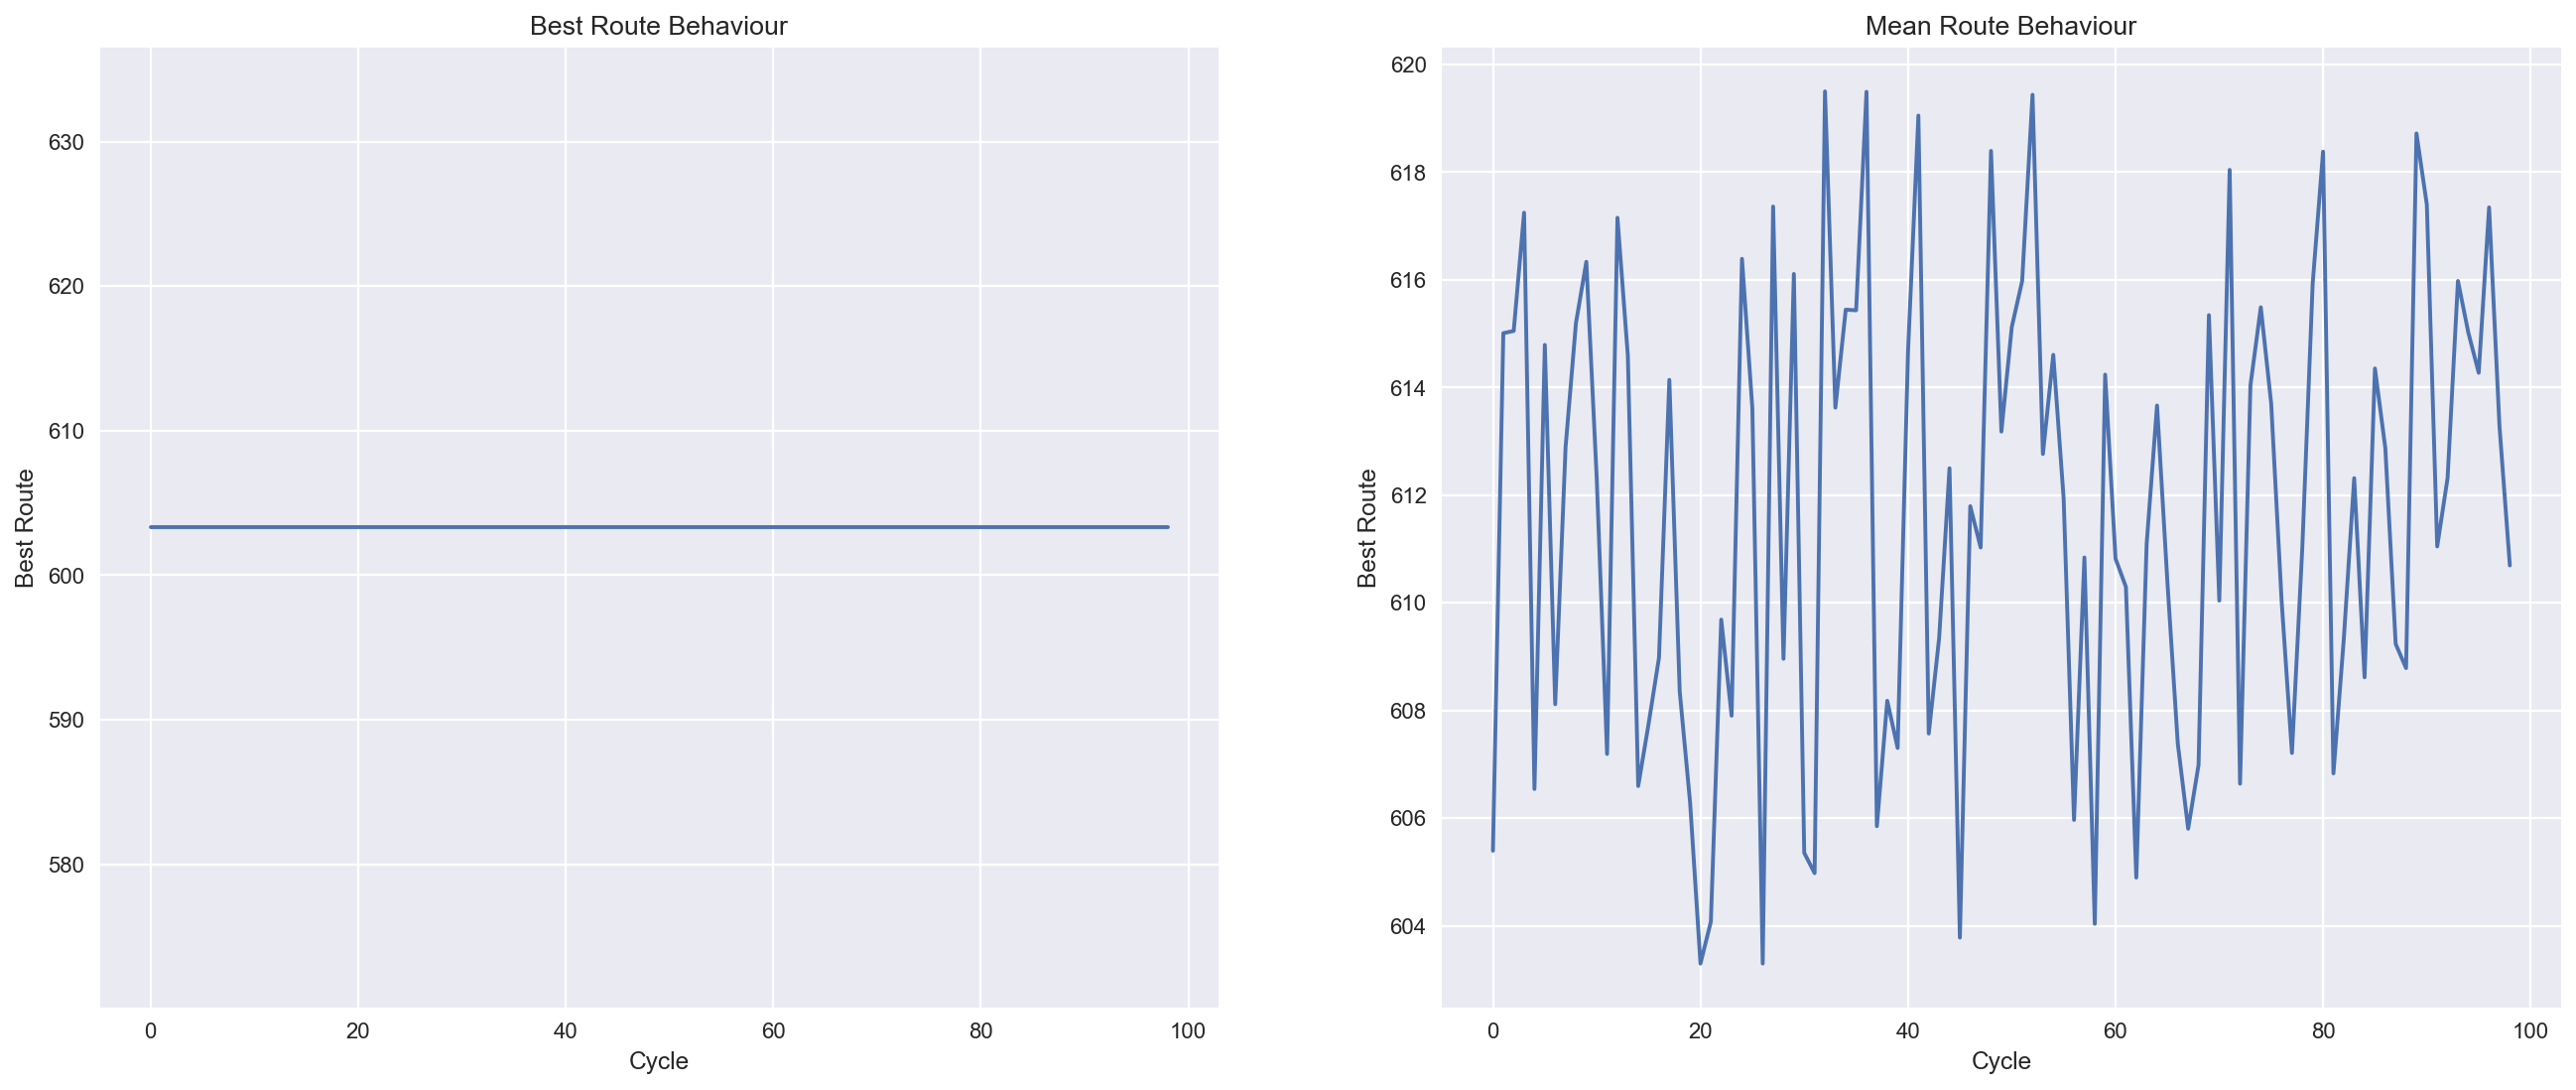

In [499]:
# ================ Main Function 96 ==================#
fcl, mcl, final_route, final_cost = ant_system(96, N96, cycle, \
                                               dist96, pheromones96, \
                                               alpha96, beta96, rho96,\
                                               Q96, random=True
                                               , verbouse=True)

In [494]:
print(final_route)

[33, 34, 37, 36, 35, 31, 30, 29, 28, 0, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 47, 46, 45, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 43, 44, 32, 10, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 78, 79, 33]


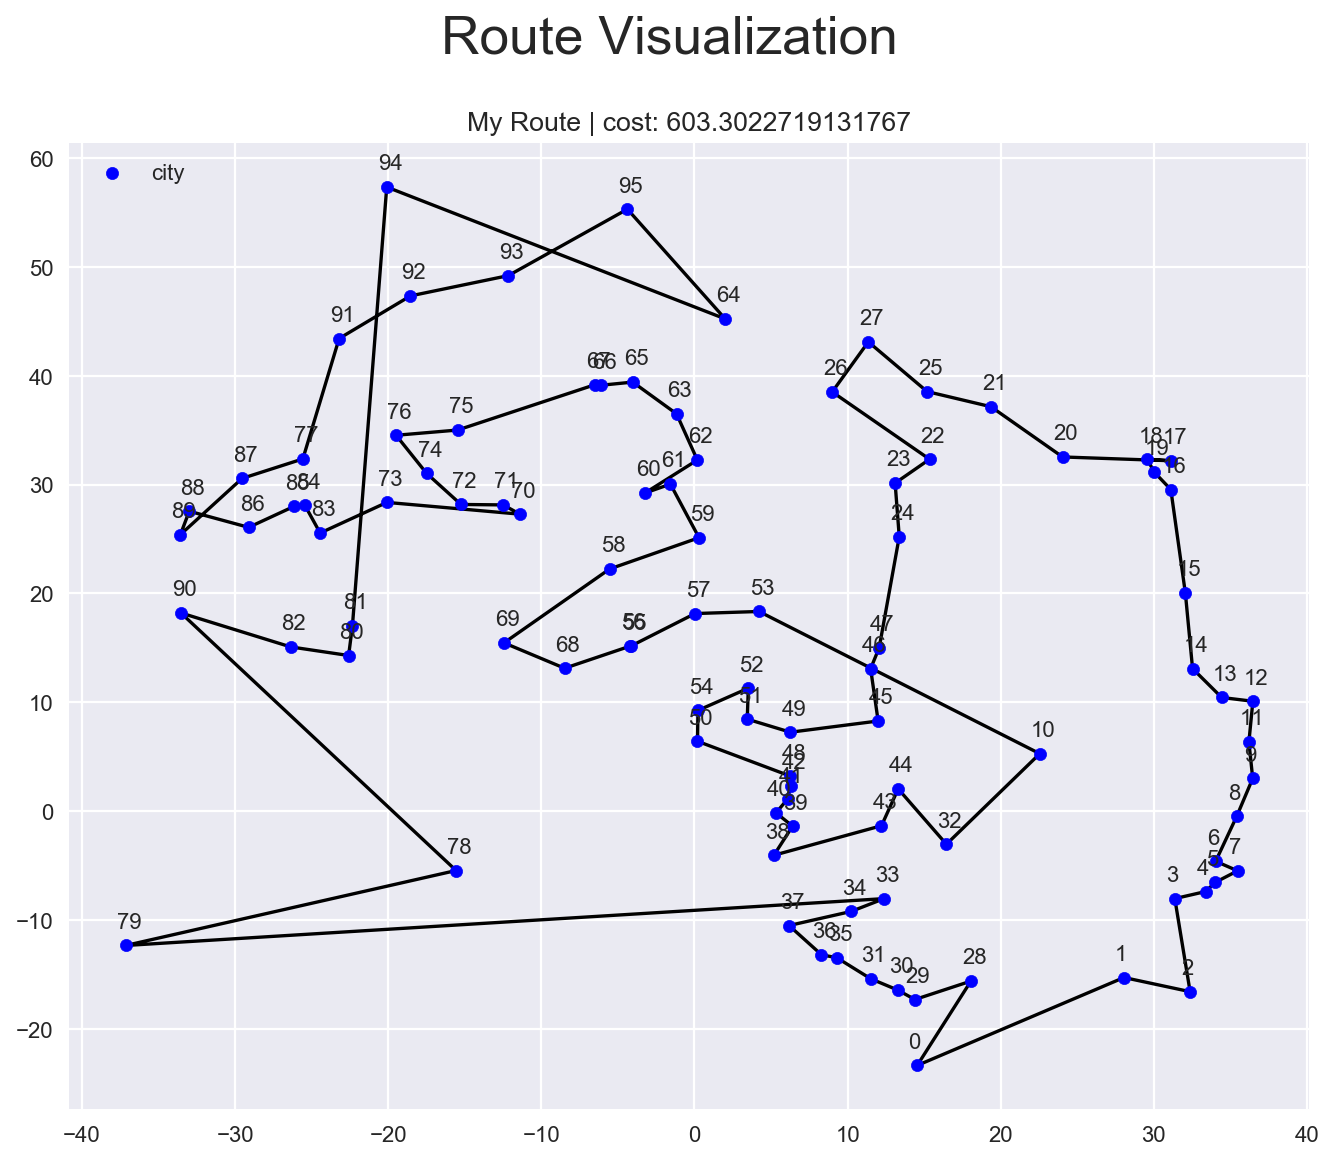

In [498]:
datas = [data96]
axes = 1
this_routes = [final_route]
titles = ["My Route | cost: "+str(cost(final_route, dist96))]

ib_scatterhs_2d(datas,axes,titles,dpi=80,node_color='b'
                ,figsize=(10,8),route=this_routes, suptitle="Route Visualization"
                , print_route=True, verbouse = True)
# print("Accuracy = 1-(mycost - bestcost)/bestcost : {}".format(1-(cost(final_route, dist16)-cost(troute, dist16))/cost(troute, dist16)))